### Packages

In [70]:
import pandas as pd
import seaborn as sns
import pickle

In [71]:
import nltk

In [157]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, precision_recall_fscore_support

In [73]:
#cleaning text is basically removing stop words, commas, full stops, lemmatizing or stemming it etc.
import re #for regular expression
from nltk.corpus import stopwords #responsible for removing stopwords
#from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer #responsible for doing lemmatizing

In [74]:
!pip install gensim
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import gensim

### Data Prerocessing

In [76]:
data = pd.read_csv('updated_inkognito_trainingset.csv')

In [77]:
df = data.iloc[:1500, :]

In [78]:
df.head()

,Unnamed: 0,text,Status
0,0,@115712 I understand. I would like to assist y...,False
1,1,@sprintcare and how do you propose we do that,False
2,2,@sprintcare I have sent several private messag...,False
3,3,@115712 Please send us a Private Message so th...,False
4,4,@sprintcare I did.,False


In [79]:
df.drop('Unnamed: 0',axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [80]:
df.head()

,text,Status
0,@115712 I understand. I would like to assist y...,False
1,@sprintcare and how do you propose we do that,False
2,@sprintcare I have sent several private messag...,False
3,@115712 Please send us a Private Message so th...,False
4,@sprintcare I did.,False


In [81]:
df['Status'].value_counts()

False    1018
True      482
Name: Status, dtype: int64

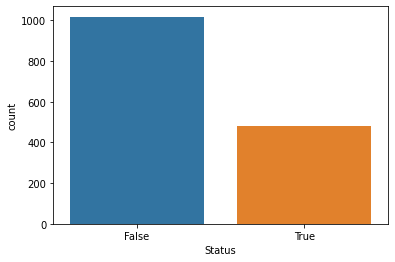

In [82]:
sns.countplot(x=df['Status']) # check the response variable counts from levelwise

In [83]:
df = pd.get_dummies(df, columns=['Status']) #to convert the categorical variable to numerical

In [84]:
df.drop('Status_False',axis=1,inplace=True) #drop 'Status_False' variable

In [85]:
df = df.rename(columns={'Status_True': 'Status'}) #rename 'Status_True' variable as 'Status'

In [86]:
df.head()
# False -> 0
# True -> 1

,text,Status
0,@115712 I understand. I would like to assist y...,0
1,@sprintcare and how do you propose we do that,0
2,@sprintcare I have sent several private messag...,0
3,@115712 Please send us a Private Message so th...,0
4,@sprintcare I did.,0


### Preprocessing the Dataset

In [87]:
#preprocess the data using 'gensim' library
review_text = df.text.apply(gensim.utils.simple_preprocess)

In [88]:
review_text

0       [understand, would, like, to, assist, you, we,...
1       [sprintcare, and, how, do, you, propose, we, d...
2       [sprintcare, have, sent, several, private, mes...
3       [please, send, us, private, message, so, that,...
4                                       [sprintcare, did]
                              ...                        
1495    [enjoying, our, booritos, from, chipotletweets...
1496               [like, your, style, my, friend, becky]
1497    [adult, trick, or, treating, for, me, is, goin...
1498          [we, look, forward, to, seeing, you, becky]
1499                      [boorito, time, chipotletweets]
Name: text, Length: 1500, dtype: object

### Building Word2Vec Model

In [89]:
#initialize the gensim model
W2V = gensim.models.Word2Vec(
        window = 10,
        min_count = 1, #minimum number of words that should be in the sentence to continue the process
        workers = 4 #how many cpu threads we want to train this model
)

In [90]:
#bulding a vocabulary / unique list of words
W2V.build_vocab(review_text, progress_per=2000)
#progress_per => how many words to process before showing/updating the progress

In [91]:
W2V.corpus_count #how many records/ number of sentences

1500

In [92]:
W2V.epochs #how many times we are going through the entire dataset to train the model

5

In [93]:
#train the model
W2V.train(review_text, total_examples=W2V.corpus_count, epochs = W2V.epochs)

(91085, 120305)

In [94]:
# save model
filename = "W2V.pickle"
with open(filename, "wb") as f:
     pickle.dump(W2V, f)

In [95]:
W2V.wv['bad'].shape #each word have 100*1 vector size according the created word2vec model

(100,)

In [96]:
W2V.wv['bad']

array([ 0.09506374, -0.00583409, -0.04087653,  0.04354278, -0.0660437 ,
       -0.03743663, -0.07066567, -0.04073519, -0.02784166,  0.00885487,
       -0.02036446, -0.03463733, -0.01271109,  0.05617815,  0.01900487,
        0.01340986,  0.04284203, -0.04293508, -0.02147085, -0.01029066,
        0.03070758,  0.07107063, -0.03982658, -0.02903325, -0.07477717,
        0.00047599,  0.00461807,  0.04010388, -0.0807116 ,  0.00679481,
        0.0327662 ,  0.01349762, -0.00271841, -0.03260982, -0.00325127,
        0.03943275, -0.02351811, -0.05576907,  0.03404259, -0.00814559,
       -0.02058946,  0.00186322, -0.02311261, -0.01982195,  0.03367937,
       -0.00296325,  0.00141831,  0.04127071, -0.09210998, -0.04683923,
       -0.0651945 , -0.02953791,  0.03484154, -0.04688461, -0.06024925,
        0.01061747, -0.03886614,  0.01381491,  0.01079807, -0.0004887 ,
       -0.03347771, -0.00615846, -0.07914069,  0.02068499, -0.01121013,
        0.01651837,  0.07423491,  0.02723919, -0.01982482, -0.01

* We have to get mean vector to apply for the ML and DL approaches

#### Build mean vecor from Word2Vec model

In [97]:
W2V.vector_size # vecotr size of the created model
import numpy as np

In [98]:
#get the mean vector for each sentence
mean_vectors = []

for record in review_text:
  record_vector = np.zeros(W2V.vector_size)
  count = 0
  for word in record:
    if word in W2V.wv:
      record_vector += W2V.wv[word]
      count += 1
  mean_vector = record_vector / count if count != 0 else record_vector
  mean_vectors.append(mean_vector)


In [99]:
mean_vectors[0].shape # shape of the fist sentence of the lenght

(100,)

In [100]:
#Reshaping the X_train so as to fit for models
import numpy as np
X_mean = np.stack(mean_vectors)

In [101]:
X_mean

array([[ 0.77439696, -0.05697956, -0.37734685, ...,  0.38176299,
         0.16034633, -0.27661806],
       [ 0.84604561, -0.06247015, -0.41379257, ...,  0.41977898,
         0.17722289, -0.30236401],
       [ 0.62627915, -0.0469151 , -0.30694878, ...,  0.31104886,
         0.13003526, -0.22263681],
       ...,
       [ 0.79154889, -0.05936954, -0.38732394, ...,  0.39197648,
         0.16426676, -0.28180546],
       [ 0.76533271, -0.05652839, -0.37403481, ...,  0.37887002,
         0.15925655, -0.27362634],
       [ 0.52186796, -0.03740133, -0.25562125, ...,  0.26058172,
         0.10604147, -0.18602315]])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_mean, df['Status'].values, test_size=1/3)

In [103]:
X_train.shape, y_train.shape

((1000, 100), (1000,))

In [104]:
X_test.shape, y_test.shape

((500, 100), (500,))

#### Handling class imbalance using SMOTE
* Training data

In [105]:
Counter(y_train) #y_train class counts

Counter({1: 324, 0: 676})

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


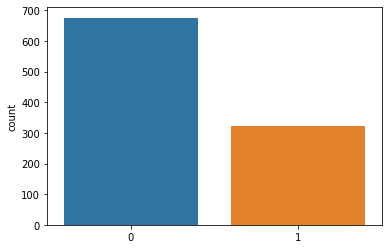

In [106]:
#class distribution of before handling the class imbalancing for training data
sns.countplot(y_train) 

In [107]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [108]:
X_train_sm.shape #3357 lemmatized words
# 1376 senetences

(1352, 100)

In [109]:
Counter(y_train_sm)
#each class have 688

Counter({1: 676, 0: 676})

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


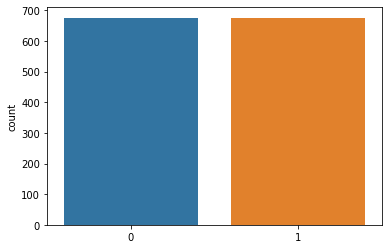

In [110]:
sns.countplot(y_train_sm) #class distribution after handling the imbalanced data for training data

In [111]:
#shape of the training data after handling the class imbalance
X_train_sm.shape, y_train_sm.shape

((1352, 100), (1352,))

* Handle the test data

In [112]:
Counter(y_test) #y_test class counts

Counter({1: 158, 0: 342})

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


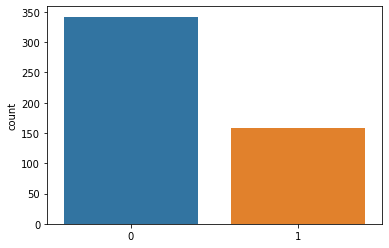

In [113]:
#class distribution of before handling the class imbalancing for training data
sns.countplot(y_test) 

In [114]:
smote = SMOTE()
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

In [115]:
X_test_sm.shape #3357 lemmatized words
# 660 senetences

(684, 100)

In [116]:
Counter(y_test_sm)
# each class have 330

Counter({1: 342, 0: 342})

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


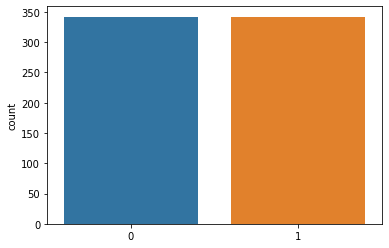

In [117]:
sns.countplot(y_test_sm) #class distribution after handling the imbalanced data for training data

In [118]:
#shape of the training data after handling the class imbalance
X_test_sm.shape, y_test_sm.shape

((684, 100), (684,))

## ML Approach

#### Logistic Regression

In [119]:
w2v_lr = GridSearchCV(LogisticRegression(),{
    'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],
    'max_iter' : [100,150],
    'multi_class' : ['auto','ovr','multinomial']
},cv = 5, return_train_score = False)
w2v_lr.fit(X_train_sm, y_train_sm)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError(
ValueError: Logisti

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 150],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [120]:
w2v_lr.best_score_

0.5524969249692496

In [121]:
w2v_lr.best_params_

{'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}

* Model Evaluation

In [122]:
#Predicting the test set result
y_pred = w2v_lr.predict(X_test_sm)
y_pred = (y_pred > 0.5)

In [123]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_sm,y_pred)
cm

array([[157, 185],
       [140, 202]])

Text(33.0, 0.5, 'Truth')

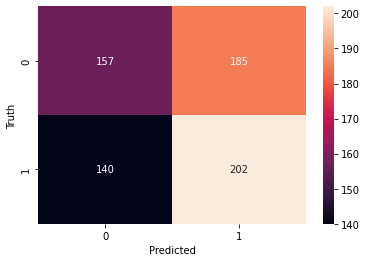

In [124]:
#from matplotlib import pyplot as plt
#import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [125]:
print(classification_report(y_test_sm, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.46      0.49       342
           1       0.52      0.59      0.55       342

    accuracy                           0.52       684
   macro avg       0.53      0.52      0.52       684
weighted avg       0.53      0.52      0.52       684



In [159]:
# Calculate the weighted F1 score
weighted_f1_score = f1_score(y_test_sm, y_pred, average='weighted')
weighted_f1_score

0.5496998518749513

#### SVM

In [126]:
w2v_svm = GridSearchCV(svm.SVC(), {
    'C': [180,160,140],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' :[1,10,20],
    'gamma': ['auto','scale']
    }, cv=5, return_train_score=False)
w2v_svm.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [180, 160, 140], 'degree': [1, 10, 20],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [127]:
w2v_svm.best_score_

0.6782533825338255

In [128]:
w2v_svm.best_params_

{'C': 180, 'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}

* Model Evaluation

In [129]:
#Predicting the test set result
y_pred = w2v_svm.predict(X_test_sm)
y_pred = (y_pred > 0.5)

In [130]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_sm,y_pred)
cm

array([[251,  91],
       [129, 213]])

Text(33.0, 0.5, 'Truth')

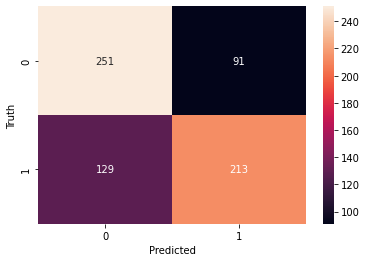

In [131]:
#from matplotlib import pyplot as plt
#import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [132]:
print(classification_report(y_test_sm, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.73      0.70       342
           1       0.70      0.62      0.66       342

    accuracy                           0.68       684
   macro avg       0.68      0.68      0.68       684
weighted avg       0.68      0.68      0.68       684



#### KNN

In [133]:
w2v_knn = GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': [1,5,10],
    'weights': ['uniform','distance']
}, cv=5, return_train_score=False)

w2v_knn.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10],
                         'weights': ['uniform', 'distance']})

In [134]:
w2v_knn.best_score_

0.7278666119994534

In [135]:
w2v_knn.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

* Model Evaluation

In [136]:
#Predicting the test set result
y_pred = w2v_knn.predict(X_test_sm)
y_pred = (y_pred > 0.5)

In [137]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_sm,y_pred)
cm

array([[191, 151],
       [124, 218]])

Text(33.0, 0.5, 'Truth')

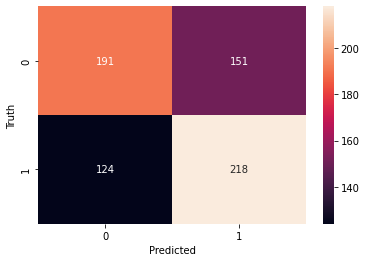

In [138]:
#from matplotlib import pyplot as plt
#import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [139]:
print(classification_report(y_test_sm, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       342
           1       0.59      0.64      0.61       342

    accuracy                           0.60       684
   macro avg       0.60      0.60      0.60       684
weighted avg       0.60      0.60      0.60       684



#### Naive Bayes

In [140]:
#w2v_nb = GridSearchCV(MultinomialNB(), {
#}, cv=5, return_train_score=False)

#w2v_nb.fit(X_w2v_smote, y_smote)

* We can not use negative values for the Naive Bayes algorithm

#### Decision Tree

In [141]:
w2v_dt = GridSearchCV(DecisionTreeClassifier(), {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features' : [[5,10,20],'auto','log2'],
    'random_state' : [5,10]
}, cv=3, return_train_score=False)

w2v_dt.fit(X_train_sm, y_train_sm)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 291, in fit
    if self.max_features > 0.0:
TypeError: '>' not supported between instances of 'list' and 'float'

  warnings.warn(s

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [[5, 10, 20], 'auto', 'log2'],
                         'random_state': [5, 10],
                         'splitter': ['best', 'random']})

In [142]:
w2v_dt.best_score_

0.7100993676603432

In [143]:
w2v_dt.best_params_

{'criterion': 'entropy',
 'max_features': 'log2',
 'random_state': 10,
 'splitter': 'random'}

* Model Evaluation

In [144]:
#Predicting the test set result
y_pred = w2v_dt.predict(X_test_sm)
y_pred = (y_pred > 0.5)

In [145]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_sm,y_pred)
cm

array([[207, 135],
       [207, 135]])

Text(33.0, 0.5, 'Truth')

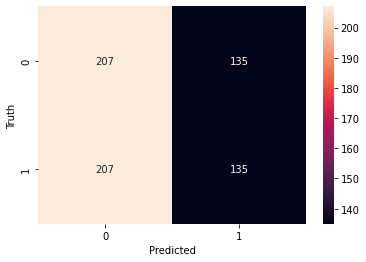

In [146]:
#from matplotlib import pyplot as plt
#import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [147]:
print(classification_report(y_test_sm, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.61      0.55       342
           1       0.50      0.39      0.44       342

    accuracy                           0.50       684
   macro avg       0.50      0.50      0.49       684
weighted avg       0.50      0.50      0.49       684



#### Random Forest

In [148]:
w2v_rf = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [1,10,5],
    'criterion': ['gini','entropy'],
    'max_features' : [30,'auto','sqrt','log2'],
    'random_state' : [5,10],
    'ccp_alpha' : [0.05,0.1,0.5],
    'max_samples' : [0.5,10,5,0.1]
}, cv=5, return_train_score=False)

w2v_rf.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.05, 0.1, 0.5],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [30, 'auto', 'sqrt', 'log2'],
                         'max_samples': [0.5, 10, 5, 0.1],
                         'n_estimators': [1, 10, 5], 'random_state': [5, 10]})

In [149]:
w2v_rf.best_score_

0.5932048653819872

In [150]:
w2v_rf.best_params_

{'ccp_alpha': 0.05,
 'criterion': 'entropy',
 'max_features': 30,
 'max_samples': 0.1,
 'n_estimators': 10,
 'random_state': 10}

* Model Evaluation

In [151]:
#Predicting the test set result
y_pred = w2v_rf.predict(X_test_sm)
y_pred = (y_pred > 0.5)

In [152]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_sm,y_pred)
cm

array([[151, 191],
       [113, 229]])

Text(33.0, 0.5, 'Truth')

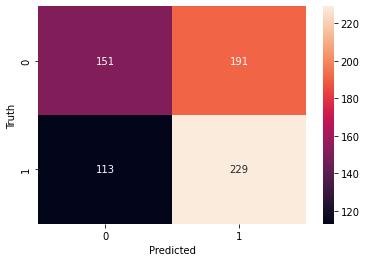

In [153]:
#from matplotlib import pyplot as plt
#import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [154]:
print(classification_report(y_test_sm, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.44      0.50       342
           1       0.55      0.67      0.60       342

    accuracy                           0.56       684
   macro avg       0.56      0.56      0.55       684
weighted avg       0.56      0.56      0.55       684



In [156]:
f1_score(y_test_sm, y_pred)

0.6010498687664042

#### Gradient Boost Classifier

In [ ]:
w2v_gbc = GridSearchCV(GradientBoostingClassifier(), {
    'loss': ['deviance','exponential'],
    'learning_rate': [1,0.5,1.5],
    'n_estimators' : [100,50,10],
    'subsample' : [1,5,0.5],
    #'criterion' : ['friedman_mse','mse', 'absolute error'],
    'random_state' : [5,10],
    'ccp_alpha' : [0.1,0.5,0.9]
}, cv=5, return_train_score=False)

w2v_gbc.fit(X_train_sm, y_train_sm )

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\Kavinda_106076\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.5, 0.9],
                         'learning_rate': [1, 0.5, 1.5],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [100, 50, 10], 'random_state': [5, 10],
                         'subsample': [1, 5, 0.5]})

In [ ]:
w2v_gbc.best_score_

0.5394882489773001

In [ ]:
w2v_gbc.best_params_

{'ccp_alpha': 0.1,
 'learning_rate': 1,
 'loss': 'exponential',
 'n_estimators': 100,
 'random_state': 5,
 'subsample': 0.5}

* Model Evaluation

In [ ]:
#Predicting the test set result
y_pred = w2v_gbc.predict(X_test_sm)
y_pred = (y_pred > 0.5)

In [ ]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_sm,y_pred)
cm

In [ ]:
#from matplotlib import pyplot as plt
#import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test_sm, y_pred))

#### XGBoost Classifier

In [ ]:
w2v_xgbc = GridSearchCV(XGBClassifier(), {
    'booster': ['gbtree','gblinear'],
    'verbosity': [0,1,2,3],
    'eta' : [0.1,0.5,0.9]
}, cv=5, return_train_score=False)

w2v_xgbc.fit(X_train_sm,y_train_sm)

[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:39] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:40] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:20:41] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:20:42] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[12:20:43] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:20:48] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:49] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:20:50] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:51] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:20:52] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:53] DEBUG: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/gbm/gbtree.cc:156: Using tree method: 2
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_pr

[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:20:53] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:20:54] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:20:54] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:20:59] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[12:20:59] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[12:20:59] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:20:59] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[12:20:59] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:00] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:21:01] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:21:02] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:03] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:21:04] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:05] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:21:06] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[12:21:08] ======== Monitor (0): Learner ========
[12:21:08] Configure: 0.000309s, 1 calls @ 309us

[12:21:08] EvalOneIter: 0.000368s, 100 calls @ 368us

[12:21:08] GetGradient: 0.003434s, 100 calls @ 3434us

[12:21:08] PredictRaw: 0.005848s, 100 calls @ 5848us

[12:21:08] UpdateOneIter: 0.023091s, 100 calls @ 23091us

[12:21:08] ======== Monitor (0): GBLinear ========
[12:21:08] DoBoost: 0.01337s, 100 calls @ 13370us

[12:21:08] PredictBatch: 0.005785s, 100 calls @ 5785us

[12:21:08] PredictBatchInternal: 0.005721s, 100 calls @ 5721us

[12:21:08] ======== Monitor (0): Learner ========
[12:21:08] Configure: 0.000366s, 1 calls @ 366us

[12:21:08] EvalOneIter: 0.000231s, 100 calls @ 231us

[12:21:08] GetGradient: 0.002034s, 100 calls @ 2034us

[12:21:08] PredictRaw: 0.004051s, 100 calls @ 4051us

[12:21:08] UpdateOneIter: 0.016485s, 100 calls @ 16485us

[12:21:08] ======== Monitor (0): GBLinear ========
[12:21:08] DoBoost: 0.009948s, 100 calls @ 9948us

[12:21:08] PredictBatch: 0.004007s

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'eta': [0.1, 0.5, 0.9], 'verbosity': [0, 1, 2, 3]})

In [ ]:
w2v_xgbc.best_score_

0.7661693537605947

In [ ]:
w2v_xgbc.best_params_

{'booster': 'gbtree', 'eta': 0.5, 'verbosity': 0}

* Model Evaluation

In [ ]:
#Predicting the test set result
y_pred = w2v_xgbc.predict(X_test_sm)
y_pred = (y_pred > 0.5)

In [ ]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_sm,y_pred)
cm

In [ ]:
#from matplotlib import pyplot as plt
#import seaborn as sn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test_sm, y_pred))